In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import survival_table_from_events

## 11.8.1 Brain Cancer Data

In [2]:
bc = pd.read_csv('../data/braincancer.csv', index_col=0)
bc.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
1,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
2,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
3,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
4,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
5,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


In [3]:
# check for missing value
bc.isnull().sum()

sex          0
diagnosis    1
loc          0
ki           0
gtv          0
stereo       0
status       0
time         0
dtype: int64

In [4]:
# fill the missing value with the most frequent value 
most_freq_val = bc['diagnosis'].mode()[0]
bc['diagnosis'].fillna(most_freq_val, inplace=True)

bc['diagnosis'].isnull().sum()

0

In [5]:
bc.sex.value_counts()

Female    45
Male      43
Name: sex, dtype: int64

In [6]:
bc.diagnosis.value_counts()

Meningioma    43
HG glioma     22
Other         14
LG glioma      9
Name: diagnosis, dtype: int64

In [7]:
bc.status.value_counts()

0    53
1    35
Name: status, dtype: int64

`status = 1` indicates an uncensored observation, and `status = 0` indicates a censored observation. But some scientists might use the opposite coding. For the `BrainCancer` data set 35 patients died before the end of the study.

In [8]:
time = bc.time
status = bc.status

kmf = KaplanMeierFitter()
kmf.fit(time, status)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 88 total observations, 53 right-censored observations>

Here `time` corresponds $y_i$, the time to the ith event (either censoring or death)

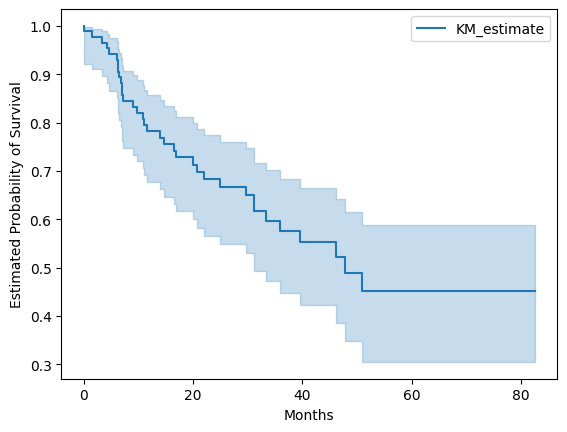

In [9]:
kmf.plot()
plt.xlabel("Months")
plt.ylabel("Estimated Probability of Survival")
plt.show()

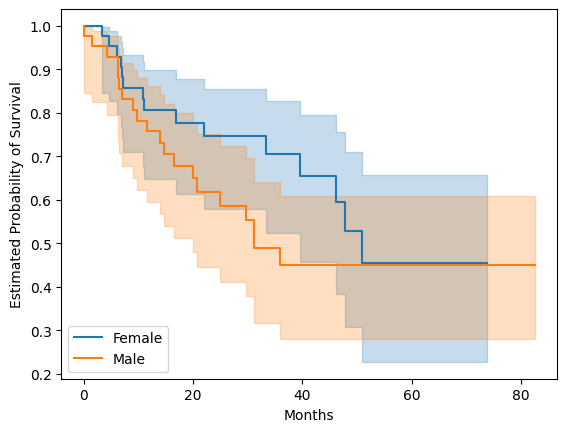

In [10]:
# Kaplan-Meier survival curves that are stratified by sex

groups = set(bc.sex)
fit_sex = KaplanMeierFitter()

for group in groups:
    ix = (bc.sex == group)
    fit_sex.fit(time[ix], status[ix])
    fit_sex.plot(label=group)
    
# Plot settings
plt.xlabel("Months")
plt.ylabel("Estimated Probability of Survival")
plt.legend(loc="lower left")
plt.show()

In [11]:
# We perform a log-rank test to compare the survival of males to females

result = logrank_test(bc.time[bc.sex == 'Male'], bc.time[bc.sex == 'Female'],
                      bc.status[bc.sex == 'Male'], bc.status[bc.sex == 'Female'])

print('Log-Rank Test Statistic: ', result.test_statistic)
print('Log-Rank Test p-value: ', result.p_value)

Log-Rank Test Statistic:  1.4404951070795842
Log-Rank Test p-value:  0.23005923816839557


The resulting p-value is 0.23, indicating no evidence of a difference in sur- vival between the two sexes.

In [12]:
# Fit Cox Proportional Hazards

cph = CoxPHFitter()
cph.fit(bc, duration_col='time', event_col='status', formula='sex')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2023-07-04 15:17:15 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex[T.Male]   0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94

              cmp to    z    p   -log2(p)
covariate                                
sex[T.Male]     0.00 1.19 0.23       2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

Regardless of which test we use, we see that there is no clear evidence for a difference in survival between males and females.

In [13]:
# Dummy coding

dummies_bc = pd.get_dummies(bc.loc[:, ['diagnosis', 'sex', 'loc', 'stereo']])
dummies_bc.drop(['diagnosis_Meningioma', 'sex_Female', 'loc_Infratentorial', 'stereo_SRS'], 
                inplace=True, axis=1)
dummies_bc.head()

,diagnosis_HG glioma,diagnosis_LG glioma,diagnosis_Other,sex_Male,loc_Supratentorial,stereo_SRT
1,0,0,0,0,0,0
2,1,0,0,1,1,1
3,0,0,0,0,0,0
4,0,1,0,0,1,1
5,1,0,0,1,1,1


In [14]:
# Concatenating with Original Data
bc.drop(['diagnosis', 'sex', 'loc', 'stereo'], inplace=True, axis=1)
bc = pd.concat([bc, dummies_bc], axis=1)
bc.head()

,ki,gtv,status,time,diagnosis_HG glioma,diagnosis_LG glioma,diagnosis_Other,sex_Male,loc_Supratentorial,stereo_SRT
1,90,6.11,0,57.64,0,0,0,0,0,0
2,90,19.35,1,8.98,1,0,0,1,1,1
3,70,7.95,0,26.46,0,0,0,0,0,0
4,80,7.61,1,47.80,0,1,0,0,1,1
5,90,5.06,1,6.30,1,0,0,1,1,1


In [15]:
columns = bc.columns
columns = [column.replace(' ', '_') for column in columns]
bc.columns = columns

In [16]:
# Fit a model that makes use of additional predictors
cph_all = CoxPHFitter()
cph_all.fit(bc, duration_col='time', event_col='status',
            formula='sex_Male + diagnosis_HG_glioma + diagnosis_LG_glioma + diagnosis_Other + loc_Supratentorial + ki + gtv + stereo_SRT')
cph_all.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -116.96
         time fit was run = 2023-07-04 15:17:15 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
sex_Male              0.17       1.18       0.36            -0.54             0.87                 0.58                 2.39
diagnosis_HG_glioma   2.19       8.91       0.45             1.31             3.07                 3.70                21.44
diagnosis_LG_glioma   0.95       2.59       0.64            -0.29             2.20                 0.75                 9.01
diagnosis_Other       0.91       2.48       0.66            -0.39             2.20                 0.68                 9.02
loc_Supratentorial    0.43       1.54       0.71            -0.95             1.82                 0.39                 6.15
ki                   -0.06       0.95       0.02            -0.09            -0.02                 0.91                 0.98
gtv                   0.03       1.04       0.02            -0.01             0.08                 0.99                 1.08
stereo_SRT            0.16       1.18       0.60            -1.02             1.34                 0.36                 3.83

                      cmp to     z      p   -log2(p)
covariate                                           
sex_Male                0.00  0.47   0.64       0.64
diagnosis_HG_glioma     0.00  4.88 <0.005      19.85
diagnosis_LG_glioma     0.00  1.50   0.13       2.91
diagnosis_Other         0.00  1.37   0.17       2.56
loc_Supratentorial      0.00  0.61   0.54       0.89
ki                      0.00 -3.04 <0.005       8.72
gtv                     0.00  1.54   0.12       3.03
stereo_SRT              0.00  0.27   0.79       0.35
---
Concordance = 0.80
Partial AIC = 249.92
log-likelihood ratio test = 42.38 on 8 df
-log2(p) of ll-ratio test = 19.73

- The `diagnosis` variable has been coded so that the baseline corresponds to meningioma. The results indicate that the risk associated with HG glioma is more than eight times (i.e. $e^{2.15} = 8.62$) the risk associated with meningioma. In other words, after adjusting for the other predictors, patients with HG glioma have much worse survival compared to those with meningioma.

- Larger values of the Karnofsky index, `ki`, are associated with lower risk, i.e. longer survival.

In [17]:
# plot survival curves for each diagnosis category
# set the values of the other predictors equal to the mean for quantitative variables, 
# and the modal value for factors

modaldata = pd.DataFrame({
    'diagnosis_HG_glioma' : np.array([0, 1, 0, 0]),
    'diagnosis_LG_glioma' : np.array([0, 0, 1, 0]),
    'diagnosis_Other' : np.array([0, 0, 0, 1]),
    'sex_Male' : np.zeros((4, )),
    'loc_Supratentorial' : np.ones((4, )),
    'ki' : [bc.ki.mean()] * 4,
    'gtv' : [bc.gtv.mean()] * 4,
    'stereo_SRT' : np.ones((4, ))
})

modaldata.head()

,diagnosis_HG_glioma,diagnosis_LG_glioma,diagnosis_Other,sex_Male,loc_Supratentorial,ki,gtv,stereo_SRT
0,0,0,0,0.0,1.0,81.022727,8.660795,1.0
1,1,0,0,0.0,1.0,81.022727,8.660795,1.0
2,0,1,0,0.0,1.0,81.022727,8.660795,1.0
3,0,0,1,0.0,1.0,81.022727,8.660795,1.0


In [18]:
# Assuming 'cph_all' is the fitted CoxPHFitter model
survival_probs = cph_all.predict_survival_function(modaldata)

survival_probs

,0,1,2,3
0.07,0.998035,0.982626,0.994908,0.995140
1.18,0.998035,0.982626,0.994908,0.995140
1.41,0.995864,0.963754,0.989303,0.989791
1.54,0.995864,0.963754,0.989303,0.989791
2.03,0.995864,0.963754,0.989303,0.989791
...,...,...,...,...
65.02,0.697229,0.040244,0.392252,0.409443
67.38,0.697229,0.040244,0.392252,0.409443
73.74,0.697229,0.040244,0.392252,0.409443
78.75,0.697229,0.040244,0.392252,0.409443


/var/folders/sf/m8d1jsv948q75r24_12s_sg00000gn/T/ipykernel_12252/1080240318.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap("tab10", len(diagnosis_names))


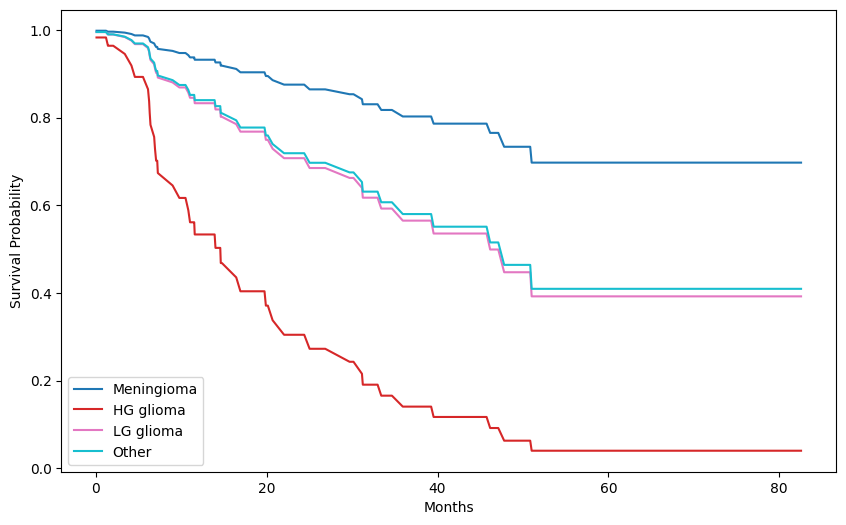

In [19]:
diagnosis_names = ["Meningioma", "HG glioma", "LG glioma", "Other"]

plt.figure(figsize=(10, 6))

color_palette = plt.cm.get_cmap("tab10", len(diagnosis_names))

for i, (diagnosis, row) in enumerate(modaldata.iterrows()):
    cumulative_hazard = cph_all.predict_cumulative_hazard(row)
    survival_prob = np.exp(-cumulative_hazard)
    plt.plot(cumulative_hazard.index, survival_prob, label=diagnosis_names[diagnosis], color=color_palette(i))

plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.legend(loc="lower left")

plt.show()

## 11.8.2 Publication Data

In [20]:
publication = pd.read_csv('../data/Publication.csv', index_col=0)
publication.head()

,posres,multi,clinend,mech,sampsize,budget,impact,time,status
1,0,0,1,R01,39876,8.016941,44.016,11.203285,1
2,0,0,1,R01,39876,8.016941,23.494,15.178645,1
3,0,0,1,R01,8171,7.612606,8.391,24.410678,1
4,0,0,1,Contract,24335,11.771928,15.402,2.595483,1
5,0,0,1,Contract,33357,76.517537,16.783,8.607803,1


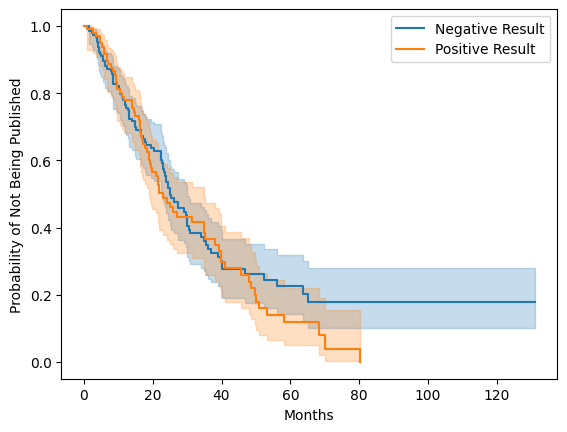

In [21]:
groups = set(publication.posres)
kmf = KaplanMeierFitter()

for group in groups:
    ix = (publication.posres == group)
    kmf.fit(publication.time[ix], publication.status[ix])
    label = 'Negative Result' if group == 0 else 'Positive Result'
    kmf.plot(label=label)
    
    
    
# Plot settings
plt.xlabel("Months")
plt.ylabel("Probability of Not Being Published")
plt.legend()
plt.show()

In [22]:
# log-rank test

results = logrank_test(publication.time[publication.posres==0], publication.time[publication.posres==1],
                      publication.status[publication.posres==0], publication.status[publication.posres==1])

print('Log-Rank Test Statistic: ', results.test_statistic)
print('Log-Rank Test p-value: ', results.p_value)

Log-Rank Test Statistic:  0.8439998569292628
Log-Rank Test p-value:  0.3582553098010103


In [23]:
# Cox Proportional Hazard

cph = CoxPHFitter()
cph.fit(publication, duration_col='time', event_col='status', formula='posres')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -723.47
         time fit was run = 2023-07-04 15:17:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.15       1.16       0.16            -0.17             0.46                 0.84                 1.59

            cmp to    z    p   -log2(p)
covariate                              
posres        0.00 0.92 0.36       1.48
---
Concordance = 0.50
Partial AIC = 1448.95
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.47

The p-value from Cox Proportional Hazards and the Log-Rank test shows that there is no evidence of a difference in time-to-publication between studies with positive versus negative results.

In [24]:
cph_all = CoxPHFitter()
cph_all.fit(publication, duration_col='time', event_col='status', 
            formula='posres + multi + clinend + sampsize + budget + impact')

cph_all.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -649.26
         time fit was run = 2023-07-04 15:17:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.57       1.77       0.18             0.23             0.92                 1.25                 2.50
multi      -0.04       0.96       0.25            -0.53             0.45                 0.59                 1.57
clinend     0.55       1.73       0.26             0.03             1.06                 1.03                 2.89
sampsize    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
budget      0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
impact      0.06       1.06       0.01             0.05             0.07                 1.05                 1.07

            cmp to     z      p   -log2(p)
covariate                                 
posres        0.00  3.24 <0.005       9.73
multi         0.00 -0.16   0.87       0.20
clinend       0.00  2.08   0.04       4.75
sampsize      0.00  0.32   0.75       0.41
budget        0.00  1.78   0.08       3.73
impact        0.00  8.74 <0.005      58.52
---
Concordance = 0.80
Partial AIC = 1310.53
log-likelihood ratio test = 149.25 on 6 df
-log2(p) of ll-ratio test = 96.18

However, the results change dramatically when we include other predictors in the model. We see that there are a number of statistically significant variables, in- cluding whether the trial focused on a clinical endpoint, the impact of the study, and whether the study had positive or negative results.